## Image Classifier using CNN.
>To build a CNN model that can classify Images as Santa or Not Santa.

<b>Importing Libraries</b>

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras.models import Sequential
from keras.models import Model

from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator,img_to_array

from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

data_path="parent folder path"

Using TensorFlow backend.


<b>Reading the Data</b>
><li>The Parent Folder contains two subfolders (santa and not_santa) which contains their corresponding images.</li><br>
><li>Read each image as 28 X 28 array of pixels.</li><br>
><li>Normalize the arrays.</li><br>
><li>Convert the arrays into Numpy arrays.</li><br>
><li>Encode the labels using binary encoding.</li>

In [ ]:
images=[]
labels=[]
data=[]
for x in os.listdir(data_path):
  if os.path.isdir(os.path.join(data_path,x)):
    for y in tqdm(os.listdir(os.path.join(data_path,x))):
      image = cv2.imread(os.path.join(data_path,x,y))
      image = cv2.resize(image, (28, 28))
      image = img_to_array(image)
      images.append(image)
      labels.append(x)
      data.append((y,x))

In [3]:
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)
encode_label=[1 if x=="santa" else 0 for x in labels] 

><b>Distribution of classes within target variable </b>

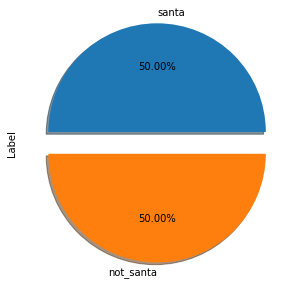

In [22]:
santa_count=np.count_nonzero(labels=="santa")
not_santa_count=np.count_nonzero(labels=="not_santa")

label = 'santa', 'not_santa'
sizes = [santa_count,not_santa_count]

explode = (0.1, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=label, autopct='%1.2f%%',shadow=True)
ax1.axis('equal')                                      # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

>><li>The classes are perfectly balanced.</li>

<b>Preparing the Data</b>


><b>Data Augmentation</b>
>><li>Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize..</li><br>
>><li>It involves creating transformed versions of images in the training dataset that belong to the same class as the original image.</li>
<br>
>><li>Transforms include a range of operations from the field of image manipulation, such as shifts, flips, zooms, and much more.</li>



In [22]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

>Consider below Image

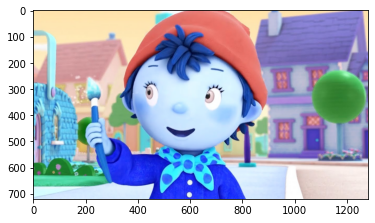

In [9]:
or_image=cv2.imread(data_path+"image3.jpg")
plt.imshow(or_image)
plt.show()

><b>Here is the output of ImageDataGenerator  for the above image of our beloved Noddy.</b>

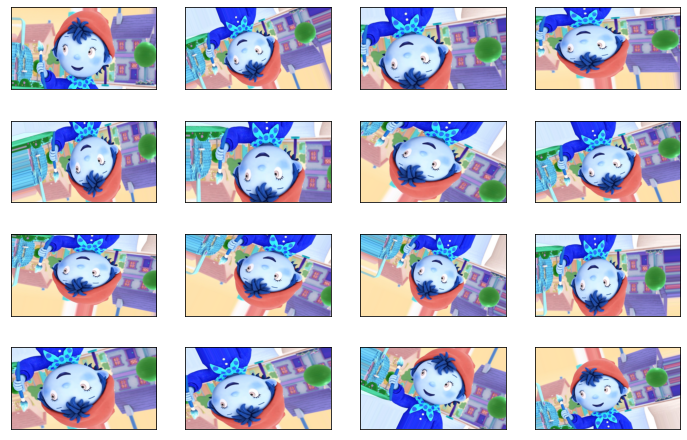

In [10]:
samples = np.expand_dims(or_image,axis=0)
image_aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,vertical_flip=True, fill_mode="nearest")
it = image_aug.flow(samples, batch_size=1)
ix=1
fig=plt.figure(figsize=(12,8))                                          #width ,height
for i in range(16):
  ax = plt.subplot(4,4,ix)
  ix=ix+1
  ax.set_xticks([])
  ax.set_yticks([])
  batch = it.next()
  image = batch[0]
  plt.imshow(image.astype('uint8'))
plt.show()

>><li>We will use this type of augmentation on our training images.</li>

><b>Train Test Split</b>

In [49]:
trainX, testX, trainY, testY = train_test_split(images,encode_label, test_size=0.25, random_state=42)
trainY = to_categorical(trainY, classes)
testY = to_categorical(testY, classes)

><b>Parameters</b>

In [21]:
height,width,depth=28,28,3
classes=2
epochs=15
INIT_LR=1e-3

<b>Model Building</b>
><b>I/P</b> -> <b>Conv</b>(20 Filters) -> activation -> Maxpooling -> <b>Conv</b>(50 Filters) -> activation -> Maxpooling -> Flatten -> <b>Dense</b>(500) -> activation -> <b>Dense</b>(2) -> activation(sigmoid) -> <b>O/P</b>

In [105]:
def build_model(height, width, depth,classes):
    model = Sequential()
    inputShape = (height, width, depth)
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2, 2)))

    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(500))
    model.add(Activation("relu"))

    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

model=build_model(height,width,depth,classes)

opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

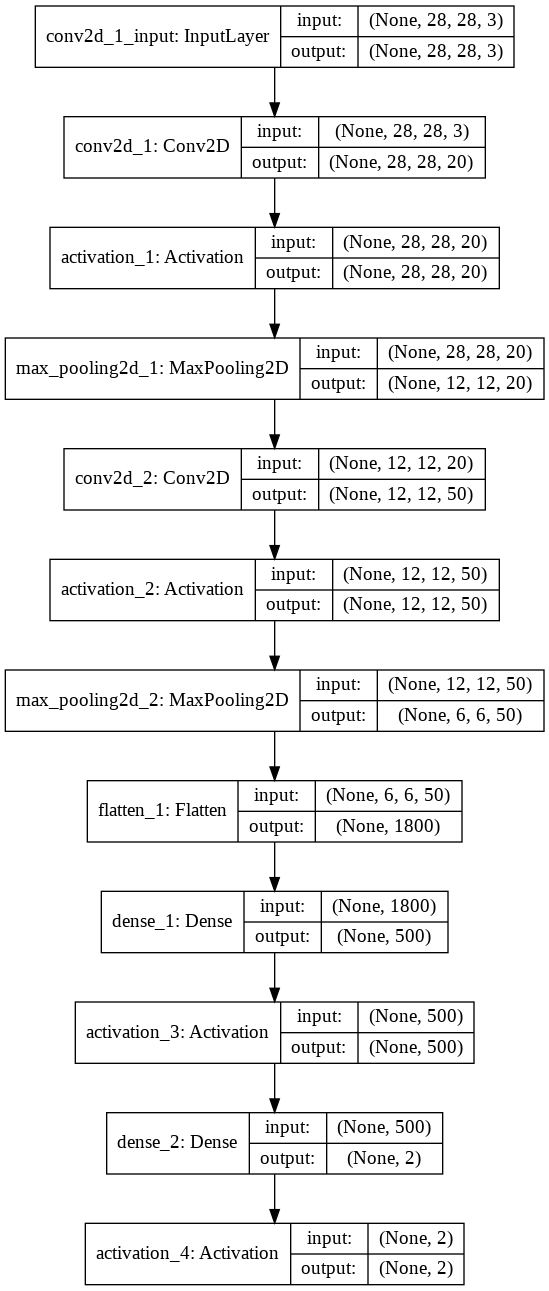

In [106]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
)

><b>Model Fitting</b>

In [58]:
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=1),
	validation_data=(testX, testY), steps_per_epoch=len(trainX),
	epochs=epochs, verbose=1)

Epoch 1/15
691/691 [==============================] - 6s 9ms/step - loss: 0.3268 - accuracy: 0.8842 - val_loss: 0.3152 - val_accuracy: 0.8658
Epoch 2/15
691/691 [==============================] - 6s 9ms/step - loss: 0.2395 - accuracy: 0.8987 - val_loss: 0.5057 - val_accuracy: 0.8009
Epoch 3/15
691/691 [==============================] - 6s 9ms/step - loss: 0.2265 - accuracy: 0.9132 - val_loss: 0.3061 - val_accuracy: 0.8701
Epoch 4/15
691/691 [==============================] - 6s 9ms/step - loss: 0.2296 - accuracy: 0.9059 - val_loss: 0.1367 - val_accuracy: 0.9394
Epoch 5/15
691/691 [==============================] - 6s 9ms/step - loss: 0.2017 - accuracy: 0.9233 - val_loss: 0.1684 - val_accuracy: 0.9177
Epoch 6/15
691/691 [==============================] - 6s 9ms/step - loss: 0.1990 - accuracy: 0.9363 - val_loss: 0.1405 - val_accuracy: 0.9524
Epoch 7/15
691/691 [==============================] - 6s 9ms/step - loss: 0.2387 - accuracy: 0.9190 - val_loss: 0.1237 - val_accuracy: 0.9481
Epoch 

><b>Training & Validation Accuracy</b>

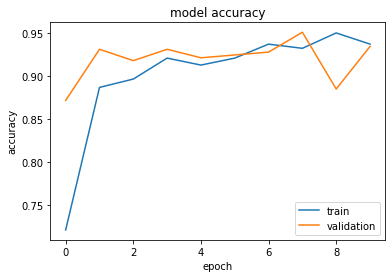

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

>><li>The separation between the training and validation curve shows overfitting after a certain epochs.</li> 

><b>Training & Validation Loss</b>

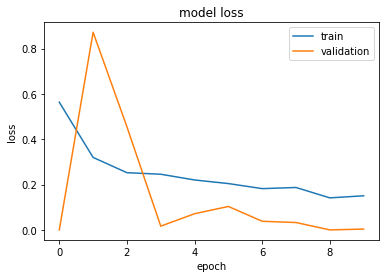

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

>><li>The separation between the training and validation curve shows overfitting after a certain epochs.</li>

<b>Filters</b>

><li>The Filters are weights learnt during the training of the network.</li><br>
><li>Stochastic Gradient Descent forces the network to learn to extract features from the image that minimize the loss for the specific task the model is being trained to solve.</li>

In [70]:
print(model.layers[0].get_weights()[0].shape)                                           
print(model.layers[0].get_weights()[1].shape)                                           #bias for each filter
print(model.layers[3].get_weights()[0].shape)                                           
print(model.layers[3].get_weights()[1].shape)                                           #bias for each filter

(5, 5, 3, 20)
(20,)
(5, 5, 20, 50)
(50,)


>><li>As it can be seen , the First Convolution layer has learnt 20 filters weight of size 5 X 5 for each input depth.</li><br>
>><li>Each filters has a bias associated with it.</li><br>
>><li>The Number of Feature Maps produced by this layer is 20.</li><br>



>><li>Also , the Second Convolution layer has learnt 50 filters weight of size 5 X 5 for each Feature Map produced by previous layer.</li><br>
>><li>Each filters has a bias associated with it.</li><br>
>><li>The Number of Feature Maps produced by this layer is 50.</li>

><b>Visualizing the Filters</b>
>><li>Let us see how filters learnt by First Convolution Layer look like.</li>

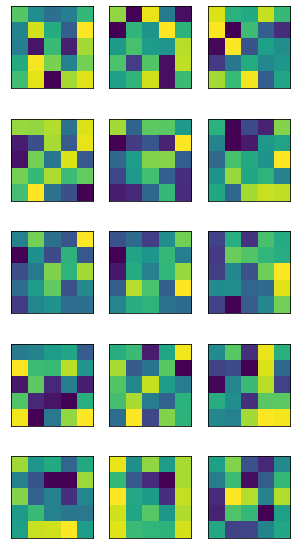

In [64]:
filters=np.array(model.layers[0].get_weights()[0])
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 5, 1                                                       # plot first 5 filters
fig=plt.figure(figsize=(5,10))                                             #width ,height
for i in range(n_filters):
	
  f = filters[:, :, :, i]                                                   # get the i'th filter
  for j in range(3):                                                        #3=RGB
    ax = plt.subplot(n_filters, 3, ix)      		                            # specify subplot and turn of axis
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, j])		                                              
    ix += 1
plt.show()

>><li>these are the first 5 filters learnt by First Convolution Layer.</li>

><li>Let us see how filters learnt by Second Convolution layer look like.</li>

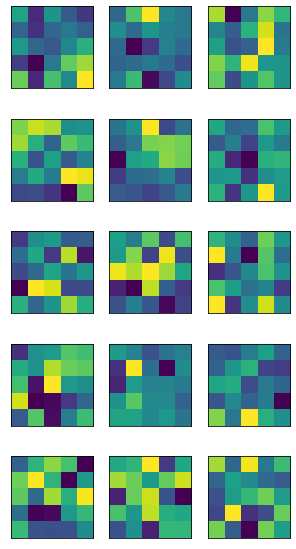

In [69]:
filters=np.array(model.layers[3].get_weights()[0])
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 5, 1                                                       # plot first 5 filters
fig=plt.figure(figsize=(5,10))                                             #width ,height
for i in range(n_filters):
	
  f = filters[:, :, :, i]                                                   # get the i'th filter
  for j in range(3):                                                        #3=RGB
    ax = plt.subplot(n_filters, 3, ix)      		                            # specify subplot and turn of axis
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, j])		                                              
    ix += 1
plt.show()

>><li>these are the first 5 filters learnt by second Convolution Layer.</li>

><b>Visualizing the Feature Map.</b>
>>Feature Maps are the outputs produced by the Convolution operation of Filters on Input Images/Feature Maps.

In [100]:
ixs = [0,3]
outputs = [model.layers[i+2].output for i in ixs]#2 is added because Conv is followed by activation and MaxPooling.
model1 = Model(inputs=model.inputs, outputs=outputs)
img=images[0]
img=np.expand_dims(img,axis=0)
feature_maps=model1.predict(img)

In [107]:
print(feature_maps[0][0].shape)
print(feature_maps[1][0].shape)

(14, 14, 20)
(7, 7, 50)


>><li>The First Feature Map is the output of (First Conv + activation + Maxpooling) layer.</li>
>><li>The dimensions of Feature Map are reduced from that of Input Image due to Maxpooling Layer.</li>

Width = ( Width - pool_size ) / stride_size + 1.<br>
Height = ( Height - pool_size) / stride_size + 1.


>><li>The Second Feature Map is the output of (Second Conv + activation + Maxpooling) layer.</li>
>><li>The dimensions of Feature Map are reduced from that of previous Feature Map due to Maxpooling Layer.</li>

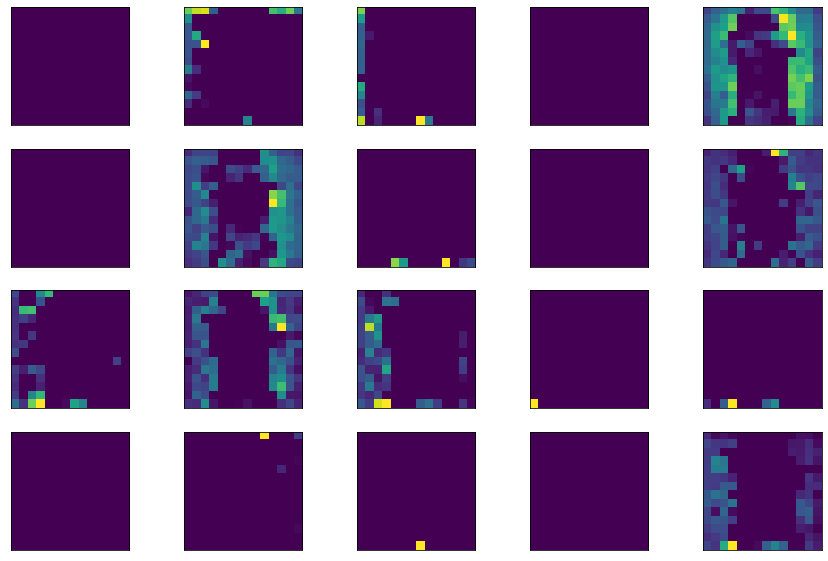

In [116]:
for fmap in feature_maps[0]:
  n_filters, ix = 20, 1
  fig=plt.figure(figsize=(15,10))
  for i in range(n_filters):
    f = fmap[ :,:, i]
    ax = plt.subplot(4,5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)
    ix += 1
  plt.show()

>>These are the First 20 Feature Maps produced by the First (Convolution+activation+MaxPooling) Layer.

><b>Feature Maps produced by the Second Convolution Layer

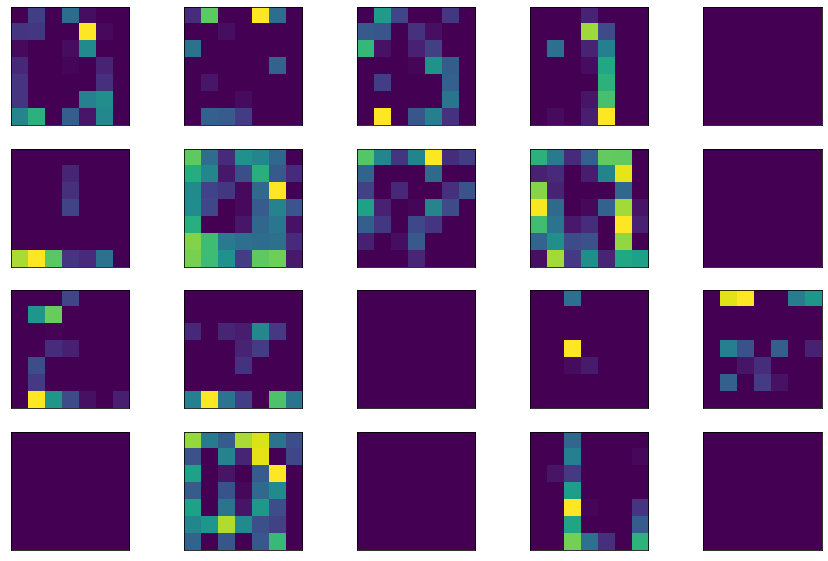

In [115]:
for fmap in feature_maps[1]:
  n_filters, ix = 20, 1
  fig=plt.figure(figsize=(15,10))
  for i in range(n_filters):
    f = fmap[ :,:, i]
    ax = plt.subplot(4,5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)
    ix += 1
  plt.show()

>>These are the First 20 Feature Maps produced by the Second (Convolution+activation+MaxPooling) Layer.

><b>Evaluation</b>
>>Let us see the Model Prediction on Random Images that were not present in train & validation dataset. 

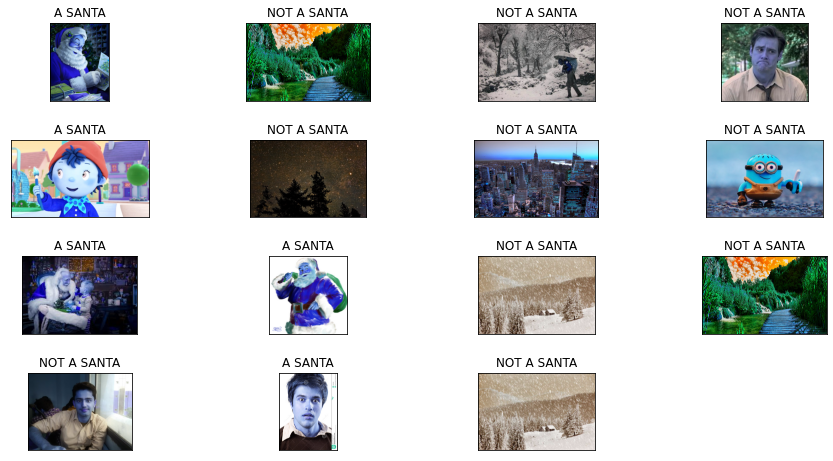

In [131]:
ix=1
fig=plt.figure(figsize=(15,10))                                          #width ,height
for i in os.listdir(data_path):
    if ((i.endswith("jpg")) or (i.endswith("jpeg")) or (i.endswith("png"))):
      or_image = cv2.imread(data_path+i)
      ax = plt.subplot(5,4,ix)
      plt.subplots_adjust(wspace=0.5,hspace=0.5)
      ix=ix+1
      ax.set_xticks([])
      ax.set_yticks([])
      image = cv2.resize(or_image, (28, 28))
      image = img_to_array(image)
      image=image/255
      image=np.expand_dims(image,axis=0)
      res=np.argmax(model.predict(image))
      if res==1:
        plt.title("A SANTA")
      else:
        plt.title("NOT A SANTA")
      plt.imshow(or_image)    
plt.show()

>>The Model is able to distinguish well between Santa and other Images with a few Exceptions like predicting Noddy as Santa although he looks very much like Santa. :)

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;END!